In [1]:
import copy
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import NNConv
import networkx as nx
import pandas as pd
import itertools
from torch_geometric.utils import from_networkx
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.utils import negative_sampling, train_test_split_edges
from sklearn.metrics import roc_auc_score, average_precision_score
from torch_geometric.loader import LinkNeighborLoader
import torch_geometric.transforms as T
import pyg_lib
from torch import Tensor
from torch_geometric.nn import SAGEConv
import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torch.nn import Sequential, Linear, ReLU
from torchmetrics.functional import auroc

In [2]:
def explode_combinations_with_inparalogs(df, cols_to_explode,
                                         protein_col='protein/inparalogs',
                                         ortholog_col='orthologs',
                                         taxid_col='taxid',
                                         ortholog_taxid_col='ortholog_taxid'):
    for col in cols_to_explode:
        df[col] = df[col].str.split(',')
    df_expanded = df.copy()
    for col in cols_to_explode:
        df_expanded = df_expanded.explode(col, ignore_index=True)
    new_rows = []
    for _, row in df.iterrows():
        proteins = row[protein_col]
        taxid = row[taxid_col]
        if isinstance(proteins, list) and len(proteins) > 1:
            for p1, p2 in itertools.combinations(proteins, 2):
                new_rows.append({
                    taxid_col: taxid,
                    protein_col: p1,
                    ortholog_col: p2,
                    ortholog_taxid_col: taxid
                })
    if new_rows:
        df_expanded_inpara = pd.DataFrame(new_rows, columns=["taxid", "protein/inparalogs", "orthologs", "ortholog_taxid"])
    return df_expanded, df_expanded_inpara

def graph_summary(G, cc):
    print("Nombre de nœuds : ", G.number_of_nodes())
    print("Nombre d’arêtes : ", G.number_of_edges())

    print("Nombre de composantes connexes : ", len(cc))
    print(f"Composante la plus grande : ", len(max(cc, key=len)))



def ortho_graph_total(path_taxid):

    #Importe liste des espèces
    id_list = []
    with open(path_taxid) as id_file:
        for l in id_file:
            id_list.append(int(l.strip()))
    print("Chargement : ", len(id_list), " espèces")

    #Importe fichiers d'orthologies
    df_ortho = pd.DataFrame(columns=["taxid", "protein/inparalogs", "orthologs", "ortholog_taxid"])
    for id in id_list:
        df = pd.read_csv("/home/schoenstein/these/test_gnn/data/" + str(id) + ".tsv", sep = "\t")
        df = df[df['ortholog_taxid'].isin(id_list)]
        df["taxid"] = id
        df_ortho = pd.concat([df_ortho, df], ignore_index = True)
    
    #Etale les paralogues
    cols_to_explode = ['protein/inparalogs', 'orthologs']
    df_ortho_split, df_inpara_split = explode_combinations_with_inparalogs(df_ortho, cols_to_explode)
    print(df_ortho_split)
    print("Chargement : ", len(df_ortho_split), " relations")

    #Crée graphe
    edges_ortho = list(zip(df_ortho_split['protein/inparalogs'], df_ortho_split['orthologs']))
    edges_inpara = list(zip(df_inpara_split['protein/inparalogs'], df_inpara_split['orthologs']))
    G = nx.Graph()
    G.add_edges_from(edges_ortho, label = "ortho")
    G.add_edges_from(edges_inpara, label = "inpara")

    #Attribue les espèces à chaque noeud
    node_taxid = pd.concat([
        df_ortho_split[['protein/inparalogs','taxid']].rename(columns={'protein/inparalogs':'node','taxid':'taxid'}),
        df_ortho_split[['orthologs','ortholog_taxid']].rename(columns={'orthologs':'node','ortholog_taxid':'taxid'})
    ])
    node_taxid_dict = pd.Series(node_taxid['taxid'].values, index=node_taxid['node']).to_dict()
    nx.set_node_attributes(G, node_taxid_dict, name='taxid')

    #Composantes connexes et leurs tailles
    cc = sorted(list(nx.connected_components(G)), key = len, reverse = True)
    list_taille = []
    for c in cc:
        list_taille.append(len(c))

    #Statistiques de base du graph
    graph_summary(G, cc)

    return G

In [ ]:
G = ortho_graph_total("/home/schoenstein/these/test_gnn/id_list_metazoa_reduce.txt")
data = from_networkx(G)

species = [G.nodes[n]['taxid'] for n in G.nodes()]
species_tensor = torch.tensor(LabelEncoder().fit_transform(species), dtype=torch.long)
species_one_hot = F.one_hot(species_tensor).float()
data.x = species_one_hot

edge_labels = [G.edges[e]['label'] for e in G.edges()]
edge_tensor = torch.tensor(LabelEncoder().fit_transform(edge_labels), dtype=torch.long)
edge_label_tensor = torch.cat([edge_tensor, edge_tensor], dim=0)
edge_one_hot = F.one_hot(edge_label_tensor).float()
data.edge_type = edge_one_hot


for key in list(data.keys()):
    if key not in ['x', 'edge_index', 'edge_type']:
        del data[key]

print(data)

Chargement :  3  espèces
      taxid protein/inparalogs   orthologs ortholog_taxid
0      7741         A0A6P5AHG9      W5LZN0           7918
1      7741         A0A6P5AMR1      W5M0K9           7918
2      7741         A0A6P4ZUP5      W5M1I4           7918
3      7741         A0A6P4YNN3      W5M5L0           7918
4      7741         A0A6P5AKH2      W5M5R0           7918
...     ...                ...         ...            ...
83509  7918             W5N1A9  A0A6P4ZN16           7741
83510  7918             W5MVK8      Q9U637           7741
83511  7918             W5MVK8  A0A6P4ZN16           7741
83512  7918             W5MTI1      Q9U637           7741
83513  7918             W5MTI1  A0A6P4ZN16           7741

[83514 rows x 4 columns]
Chargement :  83514  relations
Nombre de nœuds :  38862
Nombre d’arêtes :  63847
Nombre de composantes connexes :  11015
Composante la plus grande :  103
Data(edge_index=[2, 127694], x=[38862, 3], edge_type=[127694, 2])


In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, edge_dim):
        super().__init__()
        nn1 = nn.Sequential(nn.Linear(edge_dim, in_channels*hidden_channels), nn.ReLU())
        nn2 = nn.Sequential(nn.Linear(edge_dim, hidden_channels*hidden_channels), nn.ReLU())
        self.conv1 = NNConv(in_channels, hidden_channels, nn1, aggr='mean')
        self.conv2 = NNConv(hidden_channels, hidden_channels, nn2, aggr='mean')

    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index, edge_type)
        return x

class Classifier(torch.nn.Module):
    def forward(self, x, edge_label_index):
        src = F.normalize(x[edge_label_index[0]], dim=-1)
        dst = F.normalize(x[edge_label_index[1]], dim=-1)
        return (src*dst).sum(dim=-1)

class Model(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, edge_dim):
        super().__init__()
        self.gnn = GNN(in_channels, hidden_channels, edge_dim)
        self.classifier = Classifier()

    def forward(self, data):
        x = self.gnn(data.x, data.edge_index, data.edge_type)
        return self.classifier(x, data.edge_label_index)


def mask_edges(data, mask_ratio=0.1):
    E = data.edge_index.size(1)
    perm = torch.randperm(E)
    k = int(E * mask_ratio)

    masked_edges = data.edge_index[:, perm[:k]]           # edges à reconstruire
    remain_edges = data.edge_index[:, perm[k:]]           # edges qui restent dans le graphe

    remain_edge_type = data.edge_type[perm[k:]]

    out = copy.copy(data)
    out.edge_index = remain_edges
    out.edge_type = remain_edge_type
    out.edge_label_index = masked_edges
    out.edge_label = torch.ones(k)                        
    return out

In [ ]:
transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
)

train_data, val_data, test_data = transform(data)

for mask_ratio in [0.15]:
    print(f"--- mask_ratio = {mask_ratio} ---")

    model = Model(in_channels=train_data.x.shape[1],
                  hidden_channels=256,
                  edge_dim=train_data.edge_type.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

    for epoch in range(1, 5):
        model.train()
        optimizer.zero_grad()

        batch = mask_edges(train_data, mask_ratio=mask_ratio)
        pred = model(batch)
        y = batch.edge_label.float()

        loss = F.binary_cross_entropy_with_logits(pred, y)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(val_data)
            val_loss = F.binary_cross_entropy_with_logits(val_pred, val_data.edge_label.float())
            auc = roc_auc_score(val_data.edge_label.numpy(),
                                torch.sigmoid(val_pred).numpy())

        print(f"epoch {epoch:03d} | train loss {loss.item():.4f} | val AUC {auc:.4f} | val loss {val_loss.item():.4f}")

--- mask_ratio = 0.15 ---
epoch 001 | train loss 0.3809 | val AUC 0.6991 | val loss 0.8087
epoch 002 | train loss 0.3495 | val AUC 0.6976 | val loss 0.8097
epoch 003 | train loss 0.3320 | val AUC 0.6980 | val loss 0.8106
epoch 004 | train loss 0.3239 | val AUC 0.6976 | val loss 0.8112


Je crois qu'il faut que j'ajoute des edges négatives dans l'entrainement pour pas qu'il prédise uniquement vrai à chaque fois

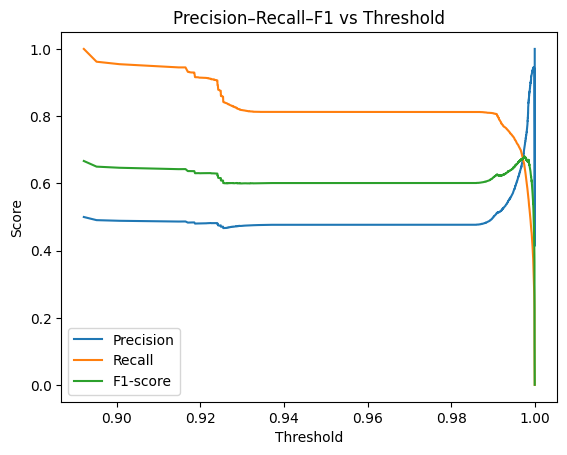

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(val_data.edge_label.float(), val_pred)
f1 = 2 * (precision * recall) / (precision + recall)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.plot(thresholds, f1[:-1], label="F1-score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision–Recall–F1 vs Threshold")
plt.show()
